# Credit Scoring

In this example we will be constructing statistical models to predict credit scores and credit approval.

We will be using the following libraries.
* ``pandas`` will load and represent our data.
* ``statsmodels`` will do the actual computation for us (ordinary least squares and linear regression).
* ``sklearn`` will do some analysis of results (confusion matrices).
* ``numpy`` is used by all of the above libraries, and we will use some functionality from it
* ``matplotlib`` will be used for visualization.

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.metrics
import sklearn.model_selection
import numpy as np
import matplotlib.pyplot as plt

# Loading and Introducing our Data

Our data for this example will be loaded from a CSV file that is shared via Google Drive. The CSV file consists of records about individuals' financial data, their credit rating, and whether or not they defaulted on the loan.

Let's load this into ``df`` and take a look at it.

In [2]:
#https://drive.google.com/file/d/1s35O0GR2gz7kYQaW8QYgbQM904AGPco6/view?usp=sharing
# download link  https://drive.google.com/uc?export=download&id=


df = pd.read_csv('https://drive.google.com/uc?export=download&id=1s35O0GR2gz7kYQaW8QYgbQM904AGPco6')


## Examining the Data and Updating Data Types

Let's take a look at the data that we have loaded.

In [3]:
df.head()

,Income,Rating,Cards,Age,Education,Gender,Student,Married,Balance,Defaulted
0,27.349,169,4,51,16,Female,No,Yes,0,Yes
1,10.403,310,3,43,7,Male,No,Yes,571,Yes
2,23.949,383,2,40,18,Male,No,Yes,829,No
3,73.914,529,6,67,15,Female,No,Yes,1048,No
4,21.038,145,2,58,13,Female,No,Yes,0,Yes


Each of the columns is implicilty given a data type, or [``numpy.dtype``](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dtype.html). Let's look at the types of each of the columns by examining [``DataFrame.dtypes``](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html).

In [4]:
df.dtypes

Income       float64
Rating         int64
Cards          int64
Age            int64
Education      int64
Gender        object
Student       object
Married       object
Balance        int64
Defaulted     object
dtype: object

The ``float64`` and ``int64`` types make sense (real numbers or integers), but the ``object`` types aren't as precise as we would like them to be.

For the ``Gender`` columns, these are categorical variables. We can convert the columns to being categories using the [``Series.astype``](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.astype.html) function.

In [5]:
df['Gender'] = df['Gender'].astype('category')
display(df.dtypes)

Income        float64
Rating          int64
Cards           int64
Age             int64
Education       int64
Gender       category
Student        object
Married        object
Balance         int64
Defaulted      object
dtype: object

For the columns that are either ``Yes`` or ``No``, let's change them to be ``boolean`` variables.

In [6]:
df['Student'] = df['Student'] == 'Yes'
df['Married'] = df['Married'] == 'Yes'
df['Defaulted'] = df['Defaulted'] == 'Yes'
display(df.dtypes)

Income        float64
Rating          int64
Cards           int64
Age             int64
Education       int64
Gender       category
Student          bool
Married          bool
Balance         int64
Defaulted        bool
dtype: object

We can also get some basic statistics by calling [``DataFrame.describe``](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html). Note that by default this will only include the numerical columns.

In [7]:
df.describe()

,Income,Rating,Cards,Age,Education,Balance
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,44.054393,348.116667,3.026667,54.983333,13.393333,502.686667
std,33.863066,150.871547,1.351064,17.216982,3.075193,466.991447
min,10.354000,93.000000,1.000000,24.000000,5.000000,0.000000
25%,21.027500,235.000000,2.000000,41.000000,11.000000,15.750000
50%,33.115500,339.000000,3.000000,55.000000,14.000000,433.500000
75%,55.975500,433.000000,4.000000,69.000000,16.000000,857.750000
max,186.634000,949.000000,8.000000,91.000000,20.000000,1809.000000


From this we can see a bit about each of our categories.
*  ``Income`` is in thousands of dollars
*  ``Rating`` is the standard credit rating
*  ``Cards`` is the number of credit cards
*  ``Age`` is in years
*  ``Education`` is also in years (clearly no humanities PhDs are in the mix)
* ``Balance`` is the average credit card debt.


We can use the parameter ``exclude=np.number`` to display only the categorical and boolean data.

In [8]:
df.describe(exclude=np.number)

,Gender,Student,Married,Defaulted
count,300,300,300,300
unique,2,2,2,2
top,Female,False,True,True
freq,168,268,183,157


Here the ``top`` row indicates what value was the most frequent, and the ``freq`` row indicates how many records had that value for their row.

The ``Defaulted`` variable indicates whether or not this individual defaulted on the loan.

## Our Goal with this Data

We will be interested in predicting two of these columns from the other columns.

*   ``Rating`` is an individual's credit rating. This is a continuous variable, and we will be using ordinary least squares to fit it.
*   ``Defaulted`` is whether or not an individual defaulted on the loan. This is a binary variable (Yes or No), and we will be using logistic regression to fit it.



## Splitting into Test and Training Data

We will be fitting a model to this data, and we will want to know how good a fit that model is, so let's split the data into test and training data.

To do this, we'll use our friend from the previous notebook, the [``sklearn.model_selection.train_test_split``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [9]:
df_train, df_test = sklearn.model_selection.train_test_split(
    df, test_size=0.5, shuffle=True, random_state=7)

print('Training Data:')
display(df_train.head())
print('')
print('Test Data:')
display(df_test.head())

Training Data:


,Income,Rating,Cards,Age,Education,Gender,Student,Married,Balance,Defaulted
63,180.379,665,3,67,8,Female,True,True,1050,False
82,53.401,377,3,35,12,Female,False,False,541,False
215,40.442,369,5,81,8,Female,False,False,510,False
208,107.986,449,4,64,14,Male,False,True,227,False
216,35.177,186,3,62,16,Female,False,False,0,True



Test Data:


,Income,Rating,Cards,Age,Education,Gender,Student,Married,Balance,Defaulted
254,55.056,235,2,31,16,Male,False,True,0,True
57,58.063,304,3,50,8,Male,False,False,118,True
150,36.362,376,3,49,15,Male,False,True,654,False
66,27.999,380,1,55,10,Male,False,True,651,True
114,19.144,269,2,75,13,Female,False,False,148,True


# Predicting ``Rating`` Using Ordinary Least Squares (OLS)

In this section, we will predict the value of ``Rating`` using the other indepdent variables. ``Rating`` is a continuous variable, and we will be fitting it using ordinary least squares.


## Computing the fit with Categorical Variables

We'll be making use of the [``statsmodels``](https://www.statsmodels.org/stable/index.html) library to do this.

Remember from above that some of our input variables are categorical, with multiple categories.

We can create dummy variables for a categorical variables in R by using the ``C()`` syntax. If we have $n$ categories, this will create $n-1$ dummy variables (it's $n-1$ instead of $n$ because one of the categories can be merged into the intercept)

Let's write out the formula that we will want to use for our model.

In [10]:
formula = ('Rating ~ Income + Cards + Education + Balance + C(Student) + C(Married)')

Now let's define ``linear_fit`` to be our [``RegressionResults``](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html), computed by calling [``linear_model.OLS.fit``](http://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.fit.html), on a [``linear_model.OLS``](http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLS.html) model.

In [11]:
linear_fit = smf.ols(formula=formula, data=df_train).fit()

## Interpreting our Model's Fit

Let's take a look at a summary of the linear model that we fit to our training data.

In [12]:
linear_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     924.9
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          1.02e-111
Time:                        11:55:36   Log-Likelihood:                -691.97
No. Observations:                 150   AIC:                             1398.
Df Residuals:                     143   BIC:                             1419.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            146.4783     10.454     14.011      0.000     125.813     167.143
C(Student)[T.True]   -98.5069      6.916    -14.243      0.000    -112.178     -84.835
C(Married)[T.True]    10.2065      4.216      2.421      0.017       1.873      18.540
Income                 2.1076      0.067     31.644      0.000       1.976       2.239
Cards                 -0.2404      1.629     -0.148      0.883      -3.460       2.979
Education             -0.0798      0.656     -0.122      0.903      -1.377       1.217
Balance                0.2285      0.005     43.944      0.000       0.218       0.239
==============================================================================
Omnibus:                       27.486   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.123
Skew:                          -1.084   Prob(JB):                     1.43e-08
Kurtosis:                       4.039   Cond. No.                     3.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What do the p-values for each independent variable tell us?

Which independent variables have the most predictive power?

## Visualizing our Model's Fit

The ``statsmodels`` package has [many helpful functions](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html) for visualizing regression plots. Let's use the [``plot_partregress_grid``](https://www.statsmodels.org/dev/generated/statsmodels.graphics.regressionplots.plot_partregress.html) function to see how effective each variable is at predicting ``Rating``.

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


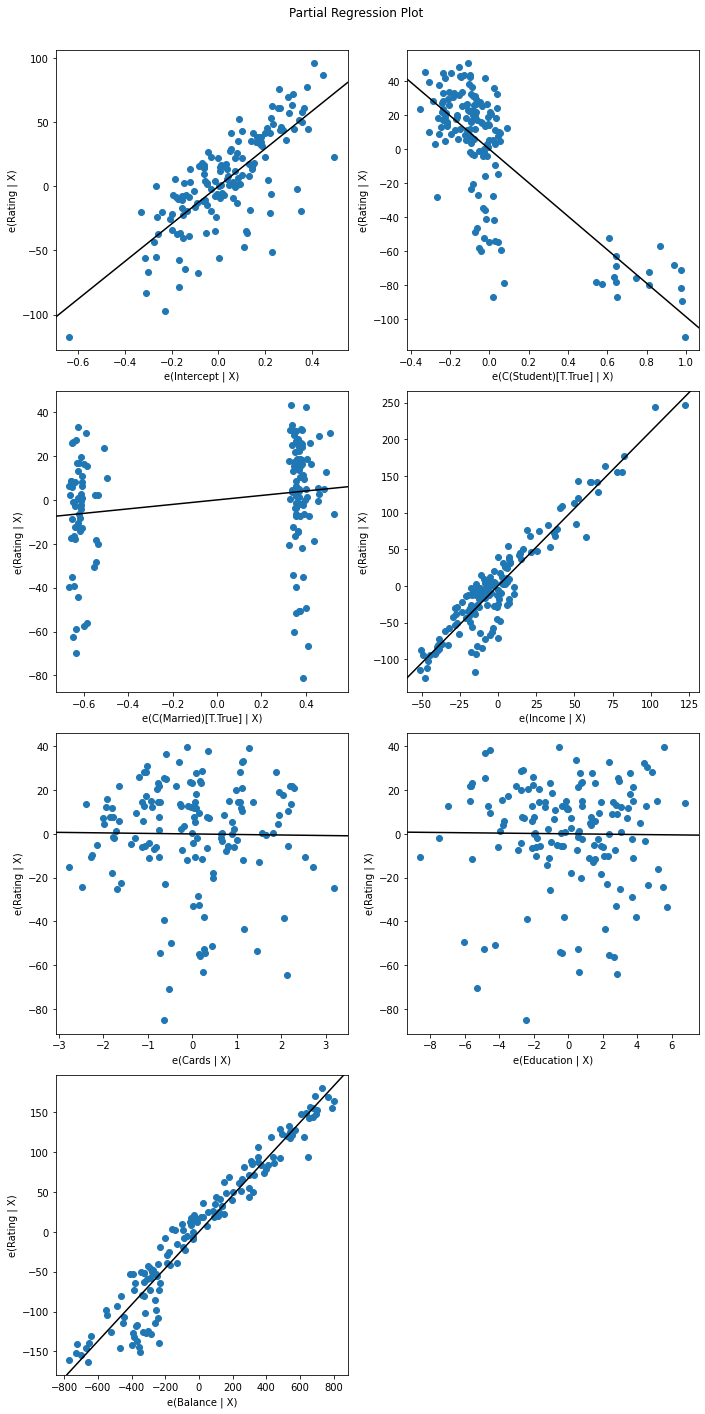

In [13]:
# Increase the figure's height, because otherwise this graph grid is squashed.
fig = plt.figure(figsize=(10,20))
sm.graphics.plot_partregress_grid(linear_fit, fig=fig)
plt.show()

Now that we know that ``Income`` and ``Balance`` are highly correlated with ``Rating``, let's just take a raw look at the relationship between the them.

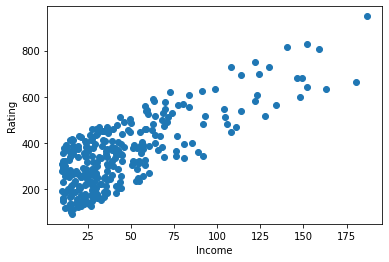

In [14]:
plt.scatter(df['Income'],  df['Rating'])
plt.xlabel('Income')
plt.ylabel('Rating')
plt.show()

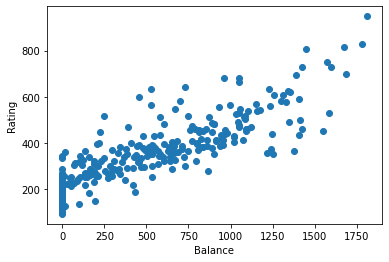

In [15]:
plt.scatter(df['Balance'],  df['Rating'])
plt.xlabel('Balance')
plt.ylabel('Rating')
plt.show()

## Evaluating our Model's Fit

Now that we have a fit, we should check its accuracy.

First, let's compute the model's predictions for the training and test sets. We do this using the [``RegressionResults.predict``](https://www.statsmodels.org/0.8.0/generated/statsmodels.regression.linear_model.RegressionResults.predict.html) function.

In [16]:
train_prediction = linear_fit.predict(df_train)
test_prediction = linear_fit.predict(df_test)

### Correlations

One way to evaluate performance of the model is to compute the correlation between the variable being predicted (the ``Rating`` column), and the prediction.

Let's start by doing this visually.

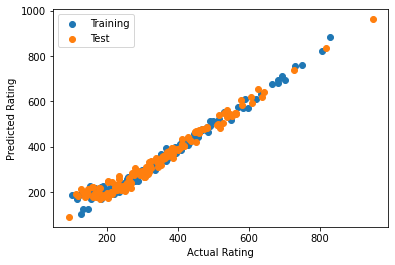

In [17]:
plt.scatter(df_train['Rating'], train_prediction, label='Training')
plt.scatter(df_test['Rating'], test_prediction, label='Test')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.legend()
plt.show()

This subjectively looks like a tight correlation, and the training data appears to be no more tightly correlated than the test data.

Now let's compute the actual correlation and compare them numerically.

In [18]:
print('Training Correlation: ' + str(train_prediction.corr(df_train['Rating'])))
print('Test Correlation:     ' + str(test_prediction.corr(df_test['Rating'])))

Training Correlation: 0.9873588723921386
Test Correlation:     0.9848066570944799


The correlations are very high, and nearly the same for both training and testing data.

What does this suggest about the accuracy of our model, and about our risk of overfitting?

```
Rob: This suggests that the risk of overfitting is low. If the correlation was high, we could expect that the correlation for training was high, and the for test was low
```

### RMSE

A more meaningful error measure is the root-mean-square error (RMSE). Let's compute that for both the training and testing data.

In [19]:
train_error = df_train['Rating'] - train_prediction
train_rmse = np.sqrt(np.mean(np.square(train_error)))
print('Training RMSE: ' + str(train_rmse))

Training RMSE: 24.39096874662449


In [20]:
test_error = df['Rating'] - test_prediction
test_rmse = np.sqrt(np.mean(np.square(test_error)))
print('Test RMSE: ' + str(test_rmse))

Test RMSE: 25.575348029345058


For a credit scores that are in the range of 50 to 1000, is this a good RMSE?

```
Rob: Yes, because the error is comparatively low too the available range
```


# Coding Dojo: A Simpler OLS Model

Earlier we asked about the meaning of the p-values in our OLS model. A low p-value for an independent variable indicates high predictive power for that variable.

In the model that we fit, we found that the ``Income``, ``Balance``, and ``Student`` independent variables had nearly-zero p-values, while the remaining variables had much higher p-values.

Create a linear model that only uses those independent variables to predict ``Rating``. Compare that test RMSE with the model that used all of the independent variables.


#### Training new model

In [21]:
formula = 'Rating ~ Income + Balance + C(Student)'

In [22]:
linear_fit2 = smf.ols(formula, df_train).fit()

In [23]:
linear_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1812.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):          2.91e-115
Time:                        11:55:38   Log-Likelihood:                -695.00
No. Observations:                 150   AIC:                             1398.
Df Residuals:                     146   BIC:                             1410.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            151.1927      3.600     42.003      0.000     144.079     158.307
C(Student)[T.True]   -99.7110      6.907    -14.437      0.000    -113.361     -86.061
Income                 2.1063      0.067     31.408      0.000       1.974       2.239
Balance                0.2285      0.005     44.106      0.000       0.218       0.239
==============================================================================
Omnibus:                       24.503   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.637
Skew:                          -1.033   Prob(JB):                     2.22e-07
Kurtosis:                       3.797   Cond. No.                     2.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Prediction of new model

In [30]:
train_prediction2 = linear_fit2.predict(df_train)
test_prediction2 = linear_fit2.predict(df_test)

#### RMSE of new prediction

In [31]:
train_rmse2 = np.sqrt(np.mean(np.square(train_prediction2 - df_train['Rating'])))
test_rmse2 = np.sqrt(np.mean(np.square(test_prediction2 - df_test['Rating'])))

#### Comparing RMSE of both models

In [32]:
print('Test RSME of model 1 (complex model) = ' + str(test_rmse))
print('Test RSME of model 2 (simplified model) = ' + str(test_rmse2))

Test RSME of model 1 (complex model) = 25.575348029345058
Test RSME of model 2 (simplified model) = 24.57303843673023


# Predicting ``Defaulted`` Using Logistic Regression

In this section we will be predicting a binary variable, ``Defaulted`` using logistic regression.

We will be using the [``statsmodels.glm``](https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html) (generalized linear model) function for this example, because its ``summary`` function allows us to examine the impact of individual parameters.

We could have equivalently used the [``statsmodels.logit``](https://www.statsmodels.org/devel/generated/statsmodels.discrete.discrete_model.Logit.html) function, which does binary logistic regression. If we had multiple classes that we wanted to predict, we could use the [``statsmodels.MNlogit``](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.MNLogit.html) function.



## Manually Examining the Data

Let's take a look at the ``Defaulted`` column of our data.

In [61]:
df_train['Defaulted'].head()

63     False
82     False
215    False
208    False
216     True
Name: Defaulted, dtype: bool

Some logistic regression functions (in particular, ``statsmodels.logit``) require that the dependent variable be an integer 0 or 1. Let's create a new column, ``DefaultedAsInt`` in our training data, using ``astype`` again. 

This will print a SettingWithCopyWarning for [unclear reasons](https://github.com/scikit-learn/scikit-learn/issues/8723).

In [62]:
df_train['DefaultedAsInt'] = df_train['Defaulted'].astype('int')

In [63]:
df_train.columns

Index(['Income', 'Rating', 'Cards', 'Age', 'Education', 'Gender', 'Student',
       'Married', 'Balance', 'Defaulted', 'DefaultedAsInt'],
      dtype='object')

In [64]:
df_train['DefaultedAsInt'].head()

63     0
82     0
215    0
208    0
216    1
Name: DefaultedAsInt, dtype: int64

## Computing the fit

Let's start with the same initial formula that we had for our linear regression, with only one change -- we are now trying to explain ``Defaulted`` instead of ``Rating``.

In [65]:
logistic_formula = ('DefaultedAsInt ~ Income + Cards + Education + '
                    'Balance +  C(Student)')
logreg_fit = smf.glm(formula=logistic_formula, data=df_train, family=sm.families.Binomial()).fit()
display(logreg_fit.summary())
# We could alternatively use the logit function
# logreg_fit = smf.logit(formula=logistic_formula, data=df_train).fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         DefaultedAsInt   No. Observations:                  150
Model:                            GLM   Df Residuals:                      144
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -58.043
Date:                Thu, 09 Mar 2023   Deviance:                       116.09
Time:                        11:43:59   Pearson chi2:                     122.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4579
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.5650      1.299      1.975      0.048       0.019       5.111
C(Student)[T.True]     2.2192      0.995      2.230      0.026       0.268       4.170
Income                -0.0250      0.010     -2.493      0.013      -0.045      -0.005
Cards                 -0.3789      0.189     -2.004      0.045      -0.749      -0.008
Education              0.1082      0.083      1.304      0.192      -0.054       0.271
Balance               -0.0044      0.001     -5.707      0.000      -0.006      -0.003
======================================================================================
"""

## Making predictions

Let's take a look at the values predicted by this model.

In [69]:
test_prediction = logreg_fit.predict(df_test)

print('Predicted test values')
display(test_prediction.head())
print('')
print('Actual test values:')
display(df_test['Defaulted'].head())

Predicted test values


254    0.896915
57     0.580621
150    0.324747
66     0.427219
114    0.889424
dtype: float64


Actual test values:


254     True
57      True
150    False
66      True
114     True
Name: Defaulted, dtype: bool

Notice that the output is not ``Yes`` or ``No``, but rather a probability of ``Yes``.

If we want to interpret these values as either ``Yes`` or ``No`` then we'll need to select a cutoff. Here we show the result of using a cutoff of 0.5 (so, 50% probability).

In [70]:
(test_prediction > 0.5).head()

254     True
57      True
150    False
66     False
114     True
dtype: bool

## Evaluating our fit

The simplest evaluation we can do is to compute the fraction of elements that we compute accurately.

In [71]:
test_accurately_predicted = df_test['Defaulted'] == (test_prediction > 0.5)
test_accurately_predicted.head()

254     True
57      True
150     True
66     False
114     True
dtype: bool

In [72]:
np.sum(test_accurately_predicted) / len(df_test)

0.78

This can be interpreted as the raw accuracy of our classifier.

### Computing Precision and Recall

Let's compute the precision and recall of our model using a cutoff of 0.5. To do this, let's compute the number of true positives, false positives, and false negatives. Note that we're using ``np.count_nonzero`` to get the number of entries that match the condition.

In [73]:
# True positives have Defaulted==True and we predicted True.
n_true_positives  = np.sum(
    (df_test['Defaulted'] == True)  & (test_prediction > 0.5))
# False positives have Defaulted==False but we predicted True
n_false_positives = np.sum(
    (df_test['Defaulted'] == False) & (test_prediction > 0.5))
# False negatives have Defaulted==True but we predicted False
n_false_negatives = np.sum(
    (df_test['Defaulted'] == True) & (test_prediction <= 0.5))

Using this we can apply our formula for precision and recall.

In [74]:
precision = n_true_positives / (n_true_positives + n_false_positives)
print('Precision: ' + str(precision))
recall    = n_true_positives / (n_true_positives + n_false_negatives)
print('Recall: ' + str(recall))

Precision: 0.7926829268292683
Recall: 0.8024691358024691


Our model has a precision of 0.79 - in other words, when it predicts a loan is not repaid, it is correct 79% of the times.

Our model has a recall of 0.80 - in other words, it correctly identifies 80% of all defaults.

### Evaluating using ``classification_report``

This can get very tedious to compute. Fortunately the ``sklearn`` library has many helpful functions for evaluating classifiers, including the [``sklearn.metrics.classification_report``](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function.

Let's take a look at its output. This function returns a dictionary for every class -- we happen to be doing binary classification here, so we just care about the ``Defaulted`` class, so just print the results for the `['True']` class.

In [75]:
display(sklearn.metrics.classification_report(
    df_test['Defaulted'], test_prediction > 0.5, output_dict=True)['True'])

{'precision': 0.7926829268292683,
 'recall': 0.8024691358024691,
 'f1-score': 0.7975460122699387,
 'support': 81}

Support refers to the number of occurrences of each label in y_true

### Adjusting cutoffs for sensitivity or specificity

Sensitivity is the ability of a test to correctly identify those who default(true positive rate), whereas test specificity is the ability of the test to correctly identify those who don't default (true negative rate).

Suppose we are particularly concerned with the recall. We could decrease the cutoff to get a higher recall (at the expense of lower precision).

In [76]:
display(sklearn.metrics.classification_report(
    df_test['Defaulted'], test_prediction > 0.25, output_dict=True)['True'])

{'precision': 0.7373737373737373,
 'recall': 0.9012345679012346,
 'f1-score': 0.8111111111111111,
 'support': 81}

### Evaluation using ``confusion_matrix``

A confusion matrix can be helpful to see where classifications are accurate. The function [``sklearn.metrics.confusion_matrix``](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) will compute this for you

In [77]:
sklearn.metrics.confusion_matrix(df_test['Defaulted'], test_prediction > 0.5)

array([[52, 17],
       [16, 65]])

This requires some interpretation.

The top row is how the true ``No`` records were classified. The top-left entry is how many ``No`` records were correctly classified as ``No``, and the top-right is how many ``No`` records were incorrectly classified as ``Yes``.

The bottom row is for the true ``Yes`` records. The bottom-right is how many ``Yes`` entries were correctly classified as ``Yes``, and the bottom-left is how many ``Yes`` records were incorrectly classified as ``No``.

### ROC Curve

The receiver operating characteristic curve, which plots true positive rate as a function of false positive rate, is a helpful tool for evaluating a classifier.

The function [``sklearn.metrics.roc_curve``](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) calculates everything that we need to know about this.

This function returns three arrays.
* The ``thresholds`` result will be a sequence of cutoff values. 
* The ``tpr`` will be the true positive rate (AKA the recall of the ``Yes`` category AKA the sensitivity of the model) at each of these thresholds.
* The ``fpr`` will be the false positive rate (AKA 1 minus the recall of the ``No`` category) at each of these thresholds.

In [78]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(df_test['Defaulted'], test_prediction)

This can be used to visualize the true positive and false positive rate as a function of threshold.

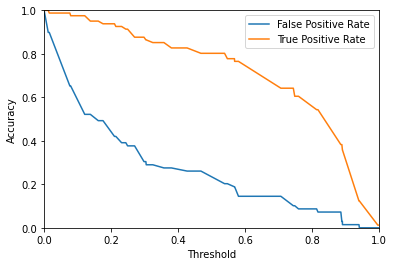

In [79]:
plt.plot(thresholds, fpr, label='False Positive Rate')
plt.plot(thresholds, tpr, label='True Positive Rate')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

Or, we can plot true positive rate as a function of false positive rate, to get the ROC curve.

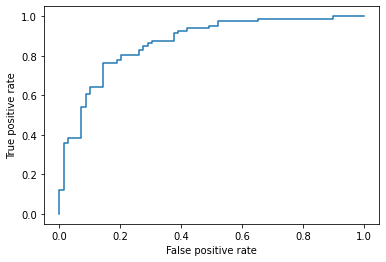

In [80]:
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

The area under the ROC curve (the AUC of the ROC) can be computed using numerical integration. The function [``numpy.trapz``](https://docs.scipy.org/doc/numpy/reference/generated/numpy.trapz.html) computes numerical integrals using the [trapeziodal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule).

In [81]:
auc = np.trapz(y=tpr, x=fpr)
display(auc)

0.8672392198962248

How do we interpret this?

```
Rob: We compare this with 0.5 to see how better our model is in comparison to just random guesses
```

---